# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

LightGBM編

## ライブラリインポート

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
#from optuna.integration import lightgbm as lgb
#import featuretools as ft

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

## 有効な関数

In [234]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## データ読み込み・前処理

In [235]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# poutcome をpseudo labeling
#p_train_df = pd.read_csv('y_train.csv')
#p_test_df = pd.read_csv('y_test.csv')

train_practice_df = pd.read_csv('train_practice.csv')
test_practice_df = pd.read_csv('test_practice.csv')

train_org_df = pd.read_csv('bank-full.csv', sep=';')

# Pseudo Labeling
test_p1_df = pd.read_csv('test_p1.csv')

submit_df = pd.read_csv('submit_sample.csv', header=None)

In [236]:
print(train_df.shape)
print(test_df.shape)
print(train_practice_df.shape)
print(test_practice_df.shape)
print(train_org_df.shape)

(27100, 18)
(18050, 17)
(27128, 18)
(18083, 17)
(45211, 17)


In [237]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27100 non-null  int64 
 1   age        27100 non-null  int64 
 2   job        27100 non-null  object
 3   marital    27100 non-null  object
 4   education  27100 non-null  object
 5   default    27100 non-null  object
 6   balance    27100 non-null  int64 
 7   housing    27100 non-null  object
 8   loan       27100 non-null  object
 9   contact    27100 non-null  object
 10  day        27100 non-null  int64 
 11  month      27100 non-null  object
 12  duration   27100 non-null  int64 
 13  campaign   27100 non-null  int64 
 14  pdays      27100 non-null  int64 
 15  previous   27100 non-null  int64 
 16  poutcome   27100 non-null  object
 17  y          27100 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [238]:
train_df['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [239]:
train_org_df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [240]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [241]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,technician,single,secondary,no,89043,no,no,cellular,7,feb,101,2,184,2,success
1,1,37,services,married,secondary,no,64372,yes,no,cellular,7,jul,158,3,241,0,unknown
2,2,31,services,single,secondary,no,31606,yes,no,unknown,15,may,152,2,47,0,unknown
3,3,31,admin.,married,secondary,no,94826,yes,no,cellular,27,may,345,2,490,0,unknown
4,4,32,services,married,secondary,no,100401,no,no,cellular,7,jan,126,1,686,0,other


In [242]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,13549.500000,36.073284,47682.901771,16.700443,229.325387,1.775830,432.482399,0.085720,0.077934
std,7823.240484,7.816417,31650.760036,8.576252,204.939958,0.950045,252.150648,0.365889,0.268072
min,0.000000,22.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6774.750000,31.000000,20015.750000,8.000000,121.000000,1.000000,214.000000,0.000000,0.000000
50%,13549.500000,33.000000,47624.000000,17.000000,158.000000,1.000000,432.000000,0.000000,0.000000
75%,20324.250000,37.000000,75330.000000,26.000000,345.000000,2.000000,650.000000,0.000000,0.000000
max,27099.000000,90.000000,102121.000000,31.000000,3076.000000,5.000000,870.000000,3.000000,1.000000


In [243]:
test_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,9024.500000,36.104266,47158.451801,16.697950,229.315014,1.770083,436.171801,0.090859
std,5210.730515,7.863805,31469.525699,8.580203,208.796946,0.944872,251.392519,0.375801
min,0.000000,20.000000,-6838.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,4512.250000,31.000000,19654.500000,8.000000,121.000000,1.000000,219.250000,0.000000
50%,9024.500000,33.000000,46886.000000,17.000000,158.000000,1.000000,436.000000,0.000000
75%,13536.750000,37.000000,74178.000000,26.000000,345.000000,2.000000,654.000000,0.000000
max,18049.000000,90.000000,102124.000000,31.000000,3076.000000,4.000000,870.000000,3.000000


In [244]:
stats = []
for col in train_df.columns:
    stats.append((col,
                  train_df[col].nunique(),
                  train_df[col].value_counts().index[0],
                  train_df[col].value_counts().values[0],
                  train_df[col].isnull().sum() * 100 / train_df.shape[0],
                  train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  train_df[col].dtype))
stats_df = pd.DataFrame(stats, columns=['カラム名', 'カラムごとのユニーク値数', '最も出現頻度の高い値', '最も出現頻度の高い値の出現回数', '欠損損値の割合', '最も多いカテゴリの割合', 'Type'])
stats_df

,カラム名,カラムごとのユニーク値数,最も出現頻度の高い値,最も出現頻度の高い値の出現回数,欠損損値の割合,最も多いカテゴリの割合,Type
0,id,27100,2047,1,0.0,0.003690,int64
1,age,42,31,4464,0.0,16.472325,int64
2,job,11,blue-collar,5957,0.0,21.981550,object
3,marital,3,married,17565,0.0,64.815498,object
4,education,4,secondary,15955,0.0,58.874539,object
5,default,2,no,27090,0.0,99.963100,object
6,balance,23967,31680,4,0.0,0.014760,int64
7,housing,2,yes,15819,0.0,58.372694,object
8,loan,2,no,23651,0.0,87.273063,object
9,contact,3,cellular,19147,0.0,70.653137,object


In [245]:
stats = []
for col in test_df.columns:
    stats.append((col,
                  test_df[col].nunique(),
                  test_df[col].value_counts().index[0],
                  test_df[col].value_counts().values[0],
                  test_df[col].isnull().sum() * 100 / test_df.shape[0],
                  test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  test_df[col].dtype))
stats_df = pd.DataFrame(stats, columns=['カラム名', 'カラムごとのユニーク値数', '最も出現頻度の高い値', '最も出現頻度の高い値の出現回数', '欠損損値の割合', '最も多いカテゴリの割合', 'Type'])
stats_df

,カラム名,カラムごとのユニーク値数,最も出現頻度の高い値,最も出現頻度の高い値の出現回数,欠損損値の割合,最も多いカテゴリの割合,Type
0,id,18050,2047,1,0.0,0.005540,int64
1,age,41,31,3068,0.0,16.997230,int64
2,job,12,blue-collar,4086,0.0,22.637119,object
3,marital,3,married,11653,0.0,64.559557,object
4,education,4,secondary,10799,0.0,59.828255,object
5,default,2,no,18046,0.0,99.977839,object
6,balance,16635,28881,5,0.0,0.027701,int64
7,housing,2,yes,10418,0.0,57.717452,object
8,loan,2,no,15729,0.0,87.141274,object
9,contact,3,cellular,12607,0.0,69.844875,object


In [246]:
# job のラベリングを y の平均の低い順にしてみる
#train_df.groupby('job').mean().sort_values('y')

In [247]:
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

train_org_df['y'] = train_org_df['y'].map(dict(yes=1, no=0))

#train_df = pd.concat([train_df, train_org_df])
train_df.shape

(27100, 17)

データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [248]:
train_df['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [249]:
train_df['poutcome'].value_counts()

unknown    23099
failure     2717
other        826
success      458
Name: poutcome, dtype: int64

In [250]:
#xx_range = np.arange(20, 91, 10)
#xx_label_mean = train_df.groupby('job')['balance'].size()
#xx_label_mean = train_df.groupby(pd.cut(train_df['age'], xx_range))['poutcome'].mean()
#xx_label_mean

In [251]:
#train_df.groupby('job')['balance'].size()

In [252]:
# one hot encoding
#train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [train_df, test_df, train_org_df]

#train_df['poutcome'] = (train_df['poutcome'] + train2_df['poutcome'] + train3_df['poutcome']) / 3
#test_df['poutcome'] = (test_df['poutcome'] + test2_df['poutcome'] + test3_df['poutcome']) / 3

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

for df in df_list:
    # Target Mean Encoding
    #df['job_label_mean'] = df['job'].map(job_label_mean)
    #df.drop(['job'], axis=1, inplace=True)

    #df['jobsize'] = df['job'].map(xx_label_mean)
    
    #df['job'] = job_encoder.transform(df['job'])
    df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})
    
    df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 0})
    #df['p_label_mean'] = np.log(df['poutcome'].map(p_label_mean))
    #df.drop(['poutcome'], axis=1, inplace=True)
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    #df['dayofyear'] = df['month'] * 31 + df['day']
    df['datetime'] = pd.to_datetime('2012/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d')
    df['dayofyear'] = df['datetime'].dt.dayofyear
    #df['dayofweek'] = df['datetime'].dt.dayofweek
    df.drop(['datetime'], axis=1, inplace=True)

    #df['duration'] = np.log(df['duration'] + 1)
    #df['bpp'] = np.log((df['balance'] - df['balance'].min()) / (df['pdays'] + 2) + 1)
    
    #df.drop(['id'], axis=1, inplace=True)
    
    df['cdp'] = (df['campaign'] - df['previous']) * df['duration']
    
    df.drop(['pdays'], axis=1, inplace=True)
    df.drop(['balance'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [253]:
#xx_range = np.arange(0, 351, 50)
xx_range = np.array([0, 250, 500, 3100])
#xx_label_mean = train_df.groupby('days')['y'].mean()
xx_label_mean = train_df.groupby(pd.cut(train_df['duration'], xx_range))['y'].mean()
xx_label_mean

duration
(0, 250]       0.094956
(250, 500]     0.015524
(500, 3100]    0.114133
Name: y, dtype: float64

In [254]:
for df in df_list:
    pass
    #df['xx_label_mean'] = df['duration'].map(xx_label_mean)

In [255]:
# Pseudo Labeling
#train_df = pd.concat([train_df, test_p1_df])

In [256]:
# poutcome を pseudo labeling
#train_df = p_train_df
#test_df = p_test_df

In [257]:
# weight
train_df['weight'] = np.where(train_df['y'] == 0, 1, 1)


In [258]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        27100 non-null  int64
 1   job        27100 non-null  int64
 2   marital    27100 non-null  int64
 3   education  27100 non-null  int64
 4   housing    27100 non-null  int64
 5   loan       27100 non-null  int64
 6   contact    27100 non-null  int64
 7   day        27100 non-null  int64
 8   month      27100 non-null  int64
 9   duration   27100 non-null  int64
 10  campaign   27100 non-null  int64
 11  previous   27100 non-null  int64
 12  poutcome   27100 non-null  int64
 13  y          27100 non-null  int64
 14  dayofyear  27100 non-null  int64
 15  cdp        27100 non-null  int64
 16  weight     27100 non-null  int64
dtypes: int64(17)
memory usage: 3.5 MB


In [259]:
train_df.head()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,dayofyear,cdp,weight
0,31,4,2,2,1,0,1,21,11,101,3,0,0,0,326,303,1
1,29,5,0,3,0,0,1,22,8,158,2,0,2,1,235,316,1
2,35,7,2,3,1,0,1,11,11,351,1,0,1,0,316,351,1
3,31,2,2,2,1,1,0,16,5,658,2,0,1,0,137,1316,1
4,48,10,2,1,1,0,2,3,4,177,1,0,2,0,94,177,1


In [260]:
test_df.head()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,dayofyear,cdp
0,35,2,0,2,0,0,1,7,2,101,2,2,3,38,0
1,37,4,2,2,1,0,1,7,7,158,3,0,2,189,474
2,31,4,0,2,1,0,0,15,5,152,2,0,2,136,304
3,31,6,2,2,1,0,1,27,5,345,2,0,2,148,690
4,32,4,2,2,0,0,1,7,1,126,1,0,0,7,126


In [261]:
train_df.describe()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,dayofyear,cdp,weight
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.0
mean,36.073284,5.152509,1.386162,2.046125,0.583727,0.127269,0.788007,16.700443,6.003542,229.325387,1.775830,0.085720,1.855683,0.077934,168.623579,370.297269,1.0
std,7.816417,2.669990,0.872384,0.727044,0.492949,0.333281,0.498535,8.576252,2.135158,204.939958,0.950045,0.365889,0.467181,0.268072,65.155774,405.680999,0.0
min,22.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,-2674.000000,1.0
25%,31.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,0.000000,2.000000,0.000000,136.000000,152.000000,1.0
50%,33.000000,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,0.000000,2.000000,0.000000,148.000000,304.000000,1.0
75%,37.000000,7.000000,2.000000,2.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,0.000000,2.000000,0.000000,199.000000,456.000000,1.0
max,90.000000,12.000000,2.000000,3.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,5.000000,3.000000,3.000000,1.000000,336.000000,9228.000000,1.0


In [262]:
test_df.describe()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,dayofyear,cdp
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,0.577175,0.128587,0.783989,16.697950,5.998726,229.315014,1.770083,0.090859,1.858061,168.471468,371.912299
std,7.863805,2.650421,0.873514,0.717774,0.494022,0.334752,0.504881,8.580203,2.118452,208.796946,0.944872,0.375801,0.464028,64.614438,436.815067
min,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,-2054.000000
25%,31.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,0.000000,2.000000,136.000000,152.000000
50%,33.000000,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,0.000000,2.000000,148.000000,304.000000
75%,37.000000,7.000000,2.000000,2.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,0.000000,2.000000,199.000000,456.000000
max,90.000000,12.000000,2.000000,3.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,4.000000,3.000000,3.000000,336.000000,12304.000000


In [263]:
# featuretools による総当り特徴量生成

#df = pd.concat([train_df, test_df])

#es = ft.EntitySet(id='bank')
#es.entity_from_dataframe(entity_id='bank', dataframe=df, index='id')
#feature_matrix, feature_defs = ft.dfs(
#    entityset=es,
#    target_entity='bank',
#    trans_primitives=['subtract_numeric'],
#    agg_primitives=[],
#    max_depth=1,
#)

#df_dict = {}
#for name, group in feature_matrix.groupby('train'):
#    df_dict[name] = group
    
#train_df = df_dict[1]
#test_df = df_dict[0]

#train_df.drop(['train'], axis=1, inplace=True)
#test_df.drop(['train'], axis=1, inplace=True)


In [264]:
#train_df.head()

In [265]:
#test_df.head()

In [266]:
#train_df.info()

In [267]:
#train_pg = sns.pairplot(train_df.drop(['month', 'day'], axis=1), hue='y')
#train_pg = sns.pairplot(train_df, hue='y')
#train_pg.savefig('train_df.png')

#test_pg = sns.pairplot(test_df)
#test_pg.savefig('test_df.png')

In [268]:
#train_df.hist(bins=50, figsize=(20, 20))
#train_df_eda_pg = sns.pairplot(train_df[['balancejob', 'y']], hue='y')
#train_df_eda_pg.savefig('train_df_eda.png')

In [269]:
#train_org_df.hist(bins=50, figsize=(20, 20))
#train_org_df_eda_pg = sns.pairplot(train_org_df[['days', 'month', 'day', 'y']], hue='y')
#train_org_df_eda_pg.savefig('train_org_df_eda.png')

In [270]:
#test_df.hist(bins=50, figsize=(20, 20))
#test_df_eda_pg = sns.pairplot(test_df[['days', 'month', 'day']])
#test_df_eda_pg.savefig('test_df_eda.png')

In [271]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 3.51 MB
Memory usage after optimization is: 0.52 MB
Decreased by 85.3%
Memory usage of dataframe is 2.07 MB
Memory usage after optimization is: 0.31 MB
Decreased by 85.0%


In [272]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        27100 non-null  int8 
 1   job        27100 non-null  int8 
 2   marital    27100 non-null  int8 
 3   education  27100 non-null  int8 
 4   housing    27100 non-null  int8 
 5   loan       27100 non-null  int8 
 6   contact    27100 non-null  int8 
 7   day        27100 non-null  int8 
 8   month      27100 non-null  int8 
 9   duration   27100 non-null  int16
 10  campaign   27100 non-null  int8 
 11  previous   27100 non-null  int8 
 12  poutcome   27100 non-null  int8 
 13  y          27100 non-null  int8 
 14  dayofyear  27100 non-null  int16
 15  cdp        27100 non-null  int16
 16  weight     27100 non-null  int8 
dtypes: int16(3), int8(14)
memory usage: 529.4 KB


## 学習準備

In [273]:
y = train_df.pop('y')

# null importance
#y = np.random.permutation(y)

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=22)

#train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
#test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False)
#final_train_set = lgb.Dataset(data=train_df, label=y, free_raw_data=False)

# weight
train_data = lgb.Dataset(data=X_train.drop("weight", axis=1), label=y_train, free_raw_data=False, weight=X_train["weight"])
test_data = lgb.Dataset(data=X_test.drop("weight", axis=1), label=y_test, free_raw_data=False, weight=X_test["weight"])

train_df.drop("weight", axis=1, inplace=True)
final_train_set = lgb.Dataset(data=train_df, label=y, free_raw_data=False)


## ハイパーパラメータ

In [274]:
lgb_params = {
    'application': 'binary',     # Binary classification
    'metric': 'auc',  # Area under ROC curve as the evaulation metric
    # 以下はoptunaでチューニングする
    'learning_rate': 0.01,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'random_state': 22
}

## 学習

In [275]:
evaluation_results = {}

clf = lgb.train(
    train_set=train_data,
    params=lgb_params,
    valid_sets=[train_data, test_data], 
    valid_names=['Train', 'Test'],
    evals_result=evaluation_results,
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=100
)
optimum_boost_rounds = clf.best_iteration

print('Result:')
print(clf.params)
print(clf.best_score)

Training until validation scores don't improve for 100 rounds
[100]	Train's auc: 0.873929	Test's auc: 0.837195
[200]	Train's auc: 0.889406	Test's auc: 0.842798
[300]	Train's auc: 0.902438	Test's auc: 0.847498
[400]	Train's auc: 0.913196	Test's auc: 0.851462
[500]	Train's auc: 0.921679	Test's auc: 0.852661
[600]	Train's auc: 0.928849	Test's auc: 0.853849
[700]	Train's auc: 0.935118	Test's auc: 0.854065
[800]	Train's auc: 0.940275	Test's auc: 0.853638
Early stopping, best iteration is:
[707]	Train's auc: 0.935517	Test's auc: 0.85417
Result:
{'application': 'binary', 'metric': 'auc', 'learning_rate': 0.01, 'min_data_in_leaf': 20, 'feature_fraction': 0.7, 'num_leaves': 41, 'drop_rate': 0.15, 'random_state': 22}
defaultdict(<class 'collections.OrderedDict'>, {'Train': OrderedDict([('auc', 0.9355170766932484)]), 'Test': OrderedDict([('auc', 0.8541704109753175)])})


## 可視化

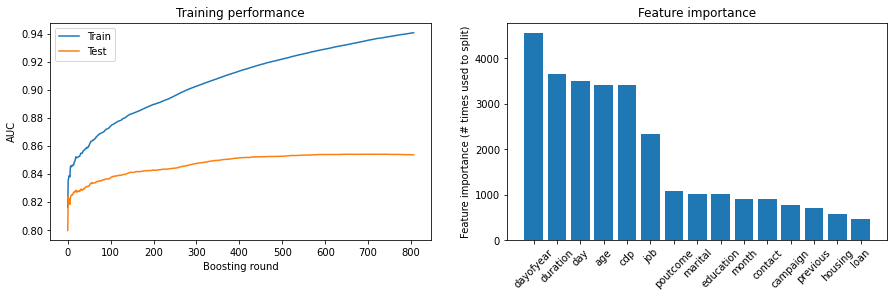

In [276]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['auc'], label='Train')
axs[0].plot(evaluation_results['Test']['auc'], label='Test')
axs[0].set_ylabel('AUC')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'], rotation = 45)
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [277]:
importances.sort_values('importance')

,features,importance
5,loan,460
4,housing,572
11,previous,709
10,campaign,765
6,contact,896
8,month,913
3,education,1011
2,marital,1017
12,poutcome,1091
1,job,2344


In [278]:
border = round(1 - y.sum() / y.count(), 2)

preds = clf.predict(train_df)
preds_df = pd.DataFrame(preds)

pred_border = float(preds_df.quantile(border))
pred_border

0.2307124085089325

In [279]:
preds

array([0.00585526, 0.12843885, 0.00624499, ..., 0.07890994, 0.03645443,
       0.00250793])

In [280]:
y_pred = np.where(preds > pred_border, 1, 0)

print('Accuracy score = \t {}'.format(accuracy_score(y, y_pred)))
print('Precision score = \t {}'.format(precision_score(y, y_pred)))
print('Recall score =   \t {}'.format(recall_score(y, y_pred)))
print('F1 score =      \t {}'.format(f1_score(y, y_pred)))

Accuracy score = 	 0.9308487084870849
Precision score = 	 0.5548892988929889
Recall score =   	 0.5696022727272727
F1 score =      	 0.5621495327102803


In [281]:
fpr, tpr, thresholds = roc_curve(y, preds)
auc_score = auc(fpr, tpr)
print(auc_score)

0.9193398721537853


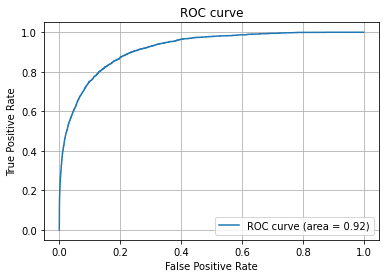

In [282]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## 推論

In [283]:
test_pred = clf.predict(test_df, num_iteration=optimum_boost_rounds)

In [284]:
submit_df[1] = test_pred
submit_df.to_csv('submit.csv', header=False, index=False)

In [285]:
#pseudo labeling

#test_df['y'] = test_pred
#test_df.to_csv('test_p1.csv', index=False)

(array([9.285e+03, 3.152e+03, 1.722e+03, 1.022e+03, 6.620e+02, 4.640e+02,
        3.430e+02, 2.620e+02, 1.770e+02, 1.600e+02, 1.140e+02, 8.600e+01,
        6.300e+01, 7.200e+01, 4.700e+01, 5.600e+01, 4.000e+01, 3.400e+01,
        3.400e+01, 2.500e+01, 1.500e+01, 2.800e+01, 2.000e+01, 2.900e+01,
        2.100e+01, 1.800e+01, 3.000e+01, 3.000e+01, 3.100e+01, 8.000e+00]),
 array([0.00138604, 0.03355349, 0.06572095, 0.0978884 , 0.13005585,
        0.16222331, 0.19439076, 0.22655822, 0.25872567, 0.29089313,
        0.32306058, 0.35522803, 0.38739549, 0.41956294, 0.4517304 ,
        0.48389785, 0.51606531, 0.54823276, 0.58040022, 0.61256767,
        0.64473512, 0.67690258, 0.70907003, 0.74123749, 0.77340494,
        0.8055724 , 0.83773985, 0.8699073 , 0.90207476, 0.93424221,
        0.96640967]),
 <BarContainer object of 30 artists>)

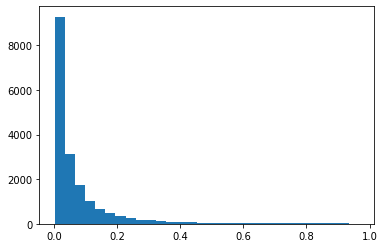

In [286]:
plt.hist(test_pred, bins=30)

In [287]:
test_pred_df = pd.DataFrame(test_pred)

In [288]:
border = round(1 - y.sum() / y.count(), 2)
border

0.92

In [289]:
percentile_list = [.01, .25, .5, .75, border]
test_pred_df.describe(percentile_list)

,0
count,18050.000000
mean,0.076206
std,0.125579
min,0.001386
1%,0.002106
25%,0.010560
50%,0.032115
75%,0.084211
92%,0.221391
max,0.966410


In [290]:
pred_border = float(test_pred_df.quantile(border))
pred_border

0.22139064240748074

In [291]:
round_test_pred = np.array(list(map(lambda x: 0 if x < pred_border else 1, test_pred)))
round_test_pred

array([1, 0, 0, ..., 0, 0, 0])

In [292]:
train_df['y'] = y
train_df['pred'] = preds
train_df['ydp'] = np.abs(y - preds)
train_df.head()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,dayofyear,cdp,y,pred,ydp
0,31,4,2,2,1,0,1,21,11,101,3,0,0,326,303,0,0.005855,0.005855
1,29,5,0,3,0,0,1,22,8,158,2,0,2,235,316,1,0.128439,0.871561
2,35,7,2,3,1,0,1,11,11,351,1,0,1,316,351,0,0.006245,0.006245
3,31,2,2,2,1,1,0,16,5,658,2,0,1,137,1316,0,0.003126,0.003126
4,48,10,2,1,1,0,2,3,4,177,1,0,2,94,177,0,0.130511,0.130511


In [293]:
pred_sort_df = train_df[(train_df['ydp'] > 0.9)].sort_values('ydp')

In [294]:
pred_sort_df.describe()

,age,job,marital,education,housing,loan,contact,day,month,duration,campaign,previous,poutcome,dayofyear,cdp,y,pred,ydp
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000
mean,36.008499,5.065156,1.373938,2.104816,0.541076,0.144476,0.654391,16.668555,6.388102,191.770538,1.994334,0.031161,1.923513,180.288952,367.648725,1.0,0.060256,0.939744
std,7.689089,2.389312,0.886516,0.668108,0.499017,0.352071,0.527202,7.764689,1.882810,154.561205,0.982790,0.189626,0.323927,58.155125,335.199451,0.0,0.025614,0.025614
min,27.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,14.000000,1.000000,0.000000,0.000000,34.000000,0.000000,1.0,0.003936,0.900000
25%,31.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,12.000000,5.000000,121.000000,1.000000,0.000000,2.000000,137.000000,158.000000,1.0,0.040318,0.916992
50%,33.000000,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,17.000000,6.000000,158.000000,2.000000,0.000000,2.000000,154.000000,304.000000,1.0,0.061729,0.938271
75%,37.000000,7.000000,2.000000,3.000000,1.000000,0.000000,1.000000,21.000000,8.000000,177.000000,3.000000,0.000000,2.000000,224.000000,474.000000,1.0,0.083008,0.959682
max,60.000000,12.000000,2.000000,3.000000,1.000000,1.000000,2.000000,30.000000,11.000000,1182.000000,4.000000,2.000000,2.000000,331.000000,3222.000000,1.0,0.100000,0.996064
